# Targets for 2D animation widgets

'Target' class discribes different target distributions for 'AnimationWidget' and its customizations like 'SamplingWidget', 'GradientDescentWidget', etc.

In [55]:
# <api>
import numpy as np
import bqplot
import warnings
from matplotlib import pyplot as plt
from ipywidgets import widgets, Layout
from IPython import display
import matplotlib

%matplotlib inline

# runtimewarning overflows ignored for now
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

# Normal distributions

In [5]:
#<api>
class Norm(object):
    '''Normal distribution.'''
    
    def __init__(self, loc, scale):
        self.sig =  scale
        self.mean = loc
        self.const = - 0.5 * np.log(2*np.pi) - np.log(self.sig)
        
    def logpdf(self, x):
        return (self.const - 0.5*((x-self.mean)**2 / self.sig**2))

In [6]:
#<api>
class Norm2D(object):
    '''2-dimensional multivariate normal distribution.'''
    
    def __init__(self, mean, cov):
        self.cov_inv = np.linalg.inv(np.array(cov))
        self.mean = mean
        self.det = cov[0][0]*cov[1][1] - cov[0][1]*cov[1][0]
        self.const = - np.log(2*np.pi) - 0.5 * np.log(self.det)
        
    def logpdf(self, xy):
        x = xy[0]
        y = xy[1]
        return (self.const - 0.5*((x-self.mean[0])**2 * self.cov_inv[0,0] + 
                                  (y-self.mean[1])**2 * self.cov_inv[1,1] +
                                  (x-self.mean[0]) * (y-self.mean[1]) * 
                                  (self.cov_inv[0,1] + self.cov_inv[1,0])))        

# Target distributions

In [7]:
#<api>
class Target(object):
    '''A class of different targets for animation.'''    
    def __init__(self):
        self.init_grid(size)
        
    def init_grid(self, size):
        '''Common block for all targets. Creates axes, grid and surface.'''
        self.size = size
        grid_size = 200
        self.x = np.linspace(-size, size, grid_size)
        self.y = np.linspace(-size, size, grid_size)
        self.X, self.Y = np.meshgrid(self.x, self.y)     
        self.XY = np.array([self.X,self.Y])        
        self.Z = self.exp_value(self.XY)
        
    #def set_param(self, param_dict):
    #    for i in param_dict:
    #        if i =='stochastic':
    #            self.stochastic = param_dict['stochastic']
        
    def plot(self):
        '''Simple plotting function for the surface (exp_value) during R&D.'''
        plt.contourf(self.X, self.Y, self.Z)
        plt.colorbar()
        plt.show()
        
    def plot_value(self):
        '''Simple plotting function for the value during R&D.'''
        v = self.value(self.XY)
        plt.contourf(self.X, self.Y, v)
        plt.colorbar()
        plt.show()
        
    def value(self, xy):
        '''Calculates functions values (logpdf for sampling) for the given point. Used only for calculation.'''
        return self.distr.logpdf(xy)
    
    def exp_value(self, xy):
        '''Calculates exponential values of the function (probability density function of this distribution
        for sampling). Used to plot the surface (heatmap).'''
        return np.exp(self.value(xy))
        
    def plot_value_and_gradient_descent(self, thetas):
        '''Simple plotting function of the accepted gradient descent steps over function values.'''
        v = self.value(self.XY)
        plt.contourf(self.X, self.Y, v)
        plt.colorbar()
        
        # only plot those theta values that lie within the boundaries of contour plot
        thetas = thetas[(np.max(thetas, axis=1) < self.size)\
                            & (np.min(thetas, axis=1) > - self.size)]
        plt.scatter(thetas[0,0], thetas[0,1], color='red', marker='x')
        plt.scatter(thetas[1:-1,0], thetas[1:-1,1], color='black', marker='x')
        plt.scatter(thetas[-1,0], thetas[-1,1], color='blue', marker='x')
        
        plt.show()
    
               
    def get_surface(self):
        '''Returns a dictionary with data to a Canvas object.'''
        return {'x':self.x, 'y':self.y, 'z':self.Z}
    
    def get_size(self):
        return self.size
    
    def get_cmap(self):
        return self.cmap
    
    def plot_surface(self):
        '''Plots the surface (heatmap) using bqplot. Used only here during R&D.'''
        # Chose the colormap
        if (self.cmap=='Blues'):
            self.col_sc = bqplot.ColorScale(scheme='Blues')
        elif (self.cmap=='Rosenblues'):
            self.col_sc = bqplot.ColorScale(colors=['#3182bd','#9ecae1','#deebf7'], max=10)
        elif (self.cmap=='Viridis'):
            self.col_sc = bqplot.ColorScale(colors=['#440154','#358779', '#fde725'])
            
        # Create axes
        self.x_sc = bqplot.LinearScale(min=-self.size, max=self.size)
        self.y_sc = bqplot.LinearScale(min=-self.size, max=self.size)
        self.ax_x = bqplot.Axis(scale=self.x_sc, orientation='horizontal', num_ticks=7)
        self.ax_y = bqplot.Axis(scale=self.y_sc, orientation='vertical', num_ticks=7)
        self.ax_c = bqplot.ColorAxis(scale=self.col_sc)
            
        # Create a heatmap 
        self.target_heat = bqplot.HeatMap(x=self.x, y=self.y, color=self.Z,  
                                          scales={'color': self.col_sc, 'x': self.x_sc, 'y': self.y_sc})
        self.canvas = bqplot.Figure(marks=[self.target_heat], axes=[self.ax_x, self.ax_y])
            
        # Set the canvases size
        self.canvas.layout.min_height = '600px'
        self.canvas.layout.min_width = '600px'
        display.display(self.canvas)
            
    def save_canvas(self, filename='bqplot.png'):
        try:
            self.canvas.save_svg(filename)
        except:
            print('Cannot find the canvas. Check that it was already created during plot_surface().')
            
    def grad(self, x):
        '''Calculates gradient of the target in given point x numerically. 
        If the analytical calculation of the gradient is possible, it should be redefined.'''
        f = lambda x: self.value(x)
        eps = 1e-4
        gradx = np.zeros_like(x)
        for i in range(x.size):
            dx = np.zeros_like(x)
            dx[i] = 1
            gradx[i] = (f(x + dx*eps/2) - f(x - dx*eps/2))/eps
        return gradx

## Multivariate normal

In [8]:
#<api>       
class MultNorm (Target):
    '''Multivariate normal target distribution'''
    def __init__(self, size=3, mean=[0,0], cov=[[1, 0.99],[0.99, 1]], cmap='Viridis'):
        self.cov_inv = np.linalg.inv(np.array(cov))
        self.mean = mean
        self.cmap = cmap
        self.distr = Norm2D(mean=mean, cov=cov)
        self.init_grid(size)

    def grad(self, xy):
        '''Analytical calculation of gradient.'''
        grad = np.array([0.,0.])
        grad[0] = - self.cov_inv[0,0]*(xy[0]-self.mean[0]) - \
                    (self.cov_inv[0,1]+self.cov_inv[1,0])*(xy[1]-self.mean[1])/2
        grad[1] = - self.cov_inv[1,1]*(xy[1]-self.mean[1]) - \
                    (self.cov_inv[0,1]+self.cov_inv[1,0])*(xy[0]-self.mean[0])/2

        return grad

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=3.0, min=-3.0)), Axis(num_ticks=7, orientation='vertical'…

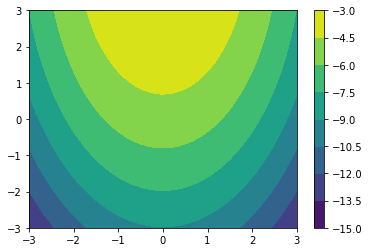

In [9]:
mn = MultNorm(size=3, mean=[0,5], cov=[[1, 0],[0, 5]])
mn.plot_surface()
mn.plot_value()

## Bimodal multivariate normal

In [10]:
#<api>
class BimodMultNorm (Target):
    '''Bimodal multivariate normal target distribution. 
    
    Arguments a1 and a2 are used to set the amplitude of the 1st and the 2nd distribution.'''
    
    def __init__(self, size=6, a1=0, mean1=[2,3], cov1=[[1, 0.1],[0.1, 1]], 
                               a2=0, mean2=[-2,-2], cov2=[[1.5, 0],[0, 1.5]], 
                               cmap='Viridis'):
        self.cmap = cmap
        self.mod1 = Norm2D(mean=mean1, cov=cov1)
        self.mod2 = Norm2D(mean=mean2, cov=cov2)        
        self.a1=a1
        self.a2=a2
        self.init_grid(size)
        
    def value(self, xy):
        return np.logaddexp(self.a1+self.mod1.logpdf(xy),self.a2+self.mod2.logpdf(xy))

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=3.0, min=-3.0)), Axis(num_ticks=7, orientation='vertical'…

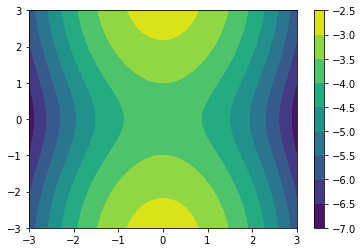

In [11]:
c = 3.7
bm = BimodMultNorm(size=3, mean1=[0,c], cov1=[[1.5, 0],[0, 4]],
                           mean2=[0,-c], cov2=[[1.5, 0],[0, 4]])
bm.plot_surface()
bm.plot_value()

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=3.0, min=-3.0)), Axis(num_ticks=7, orientation='vertical'…

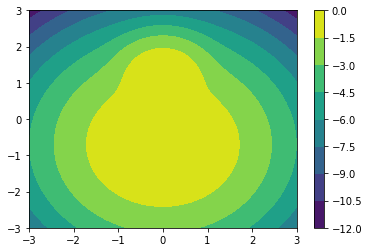

In [12]:
bb8 = BimodMultNorm(size=3, a1=0, mean1=[0,1.2], cov1=[[.2, 0],[0, .2]], 
                            a2=1.8, mean2=[0,-0.7], cov2=[[1, 0],[0, 1]])
bb8.plot_surface()
bb8.plot_value()

## Donut

In [13]:
#<api>
class Donut (Target):
    '''Donut distribution using polar coorinates'''
    
    def __init__(self, size=4, mean=2, variance=0.4, cmap='Viridis'):        
        #self.start_point = [-3.5, -3.5]
        self.std = variance
        self.mean = mean
        self.cmap = cmap
        self.rad_distr = Norm(loc=mean, scale=variance)
        self.init_grid(size)

    def value(self, xy): 
        x = xy[0]
        y = xy[1]
        return self.rad_distr.logpdf(np.sqrt(x**2 + y**2))
    
    def grad(self, xy):
        grad = np.array([0., 0.])
        temp = - (1 - self.mean/np.sqrt(xy[0]**2 + xy[1]**2))/self.std**2
        grad[0] = xy[0]*temp
        grad[1] = xy[1]*temp
        
        return grad

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=4.0, min=-4.0)), Axis(num_ticks=7, orientation='vertical'…

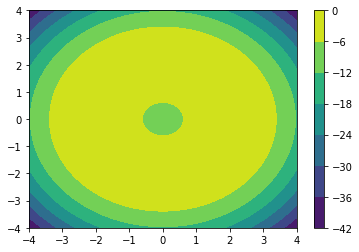

In [14]:
dr = Donut()
dr.plot_surface()
dr.plot_value()

In [15]:
#<api>
class Donut_min (Donut):
    '''Donut distribution with the global minimum in the center.'''
    
    def __init__(self, size=4, mean=2, variance=0.4, cmap='Viridis'):
        self.std = variance
        self.mean = mean        
        self.cmap = cmap
        self.rad_distr = Norm(loc=mean, scale=variance)
        min_distr_std = 0.5
        self.min_distr = Norm2D(mean=[0,0], cov=[[min_distr_std, 0],[0, min_distr_std]]) 
        self.init_grid(size)

    def value(self, xy):
        x = xy[0]
        y = xy[1]
        return np.logaddexp(self.rad_distr.logpdf(np.sqrt(x**2 + y**2)), 1/self.min_distr.logpdf(xy))      

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=4.0, min=-4.0)), Axis(num_ticks=7, orientation='vertical'…

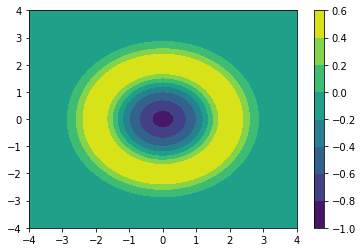

In [16]:
dm = Donut_min()
dm.plot_surface()
dm.plot_value()

In [17]:
#<api>
class Donut_max (Target):
    '''Donut distribution with the global maximum in the center.'''
    
    def __init__(self, size=4, mean=2, variance=0.6, cmap='Viridis'):
        self.std = variance
        self.mean = mean        
        self.cmap = cmap
        self.rad_distr = Norm(loc=mean, scale=variance)
        min_distr_std = 0.8
        self.min_distr = Norm2D(mean=[0,0], cov=[[min_distr_std, 0],[0, min_distr_std]]) 
        self.init_grid(size)

    def value(self, xy):
        x = xy[0]
        y = xy[1]
        return np.logaddexp(0.01/self.rad_distr.logpdf(np.sqrt(x**2 + y**2)), 3*self.min_distr.logpdf(xy))      

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=4.0, min=-4.0)), Axis(num_ticks=7, orientation='vertical'…

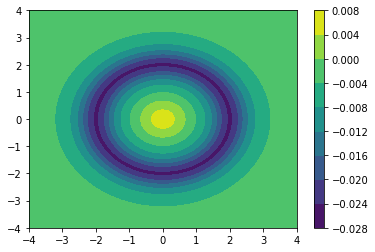

In [18]:
dmax = Donut_max()
dmax.plot_surface()
dmax.plot_value()

## Rosenbrock (banana) function

In [19]:
#<api>
class Rosenbrock (Target):
    '''Inversed Rosenbrock function (banana function with a global maximum 
    instead of global minimum)'''
    
    def __init__(self, size=3, a=0, b=20, cmap='Viridis'):
        self.cmap = cmap
        self.a = a
        self.b = b         
        self.init_grid(size)
    
    def value(self, xy):
        x = xy[0]
        y = xy[1]
        return -((self.a-x)**2 + self.b*(y-x*x)**2)
    
    def grad(self, xy):
        '''Analytical calculation of gradient. Not stable, therefore, 
        it is not currently used.'''
        grad = np.array([0., 0.])
        grad[0] = 2*(self.a - xy[0]) + 4*self.b*xy[0]*(xy[1] - xy[0]**2)
        grad[1] = - 2*self.b*(xy[1] - xy[0]**2)
        return grad

Figure(axes=[Axis(num_ticks=7, scale=LinearScale(max=2.0, min=-2.0)), Axis(num_ticks=7, orientation='vertical'…

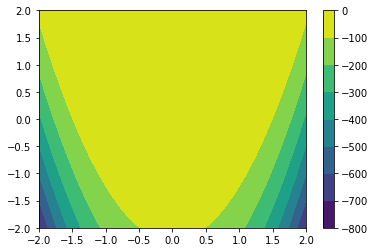

In [20]:
r = Rosenbrock(size=2)
r.plot_surface()
r.plot_value()

# MLP_target

In [56]:
#<api>
class MLP_target (Target):
    '''Special target for MLP widget. Includes samples from two multivariate normal distributions.'''
    
    def __init__(self, size=2, mean1=[-0.8, 0.8], cov1=[[0.1, 0.],[0., 0.1]], 
                               mean2=[0.8, -0.8], cov2=[[0.1, 0.],[0., 0.1]],
                n_samples_per_class=100):
        self.size = size

        data_samples = np.concatenate((np.random.multivariate_normal(mean1, cov1, n_samples_per_class),\
                             np.random.multivariate_normal(mean2, cov2, n_samples_per_class))).T
        data_classes = np.concatenate((np.ones(n_samples_per_class), np.zeros(n_samples_per_class)))

        # randomly shuffle data
        permutation = np.random.permutation(data_samples.shape[1])
        data_samples = data_samples[:,permutation]
        self.Z = data_classes[permutation]
        self.X = data_samples[0]
        self.Y = data_samples[1]
        
    def plot(self):
        '''Simple plotting function for the surface (exp_value) during R&D.'''
        colors = ['orange', 'blue']
        plt.scatter(self.X, self.Y, c=self.Z, cmap=matplotlib.colors.ListedColormap(colors))    
        plt.xlim([-self.size,self.size])
        plt.ylim([-self.size,self.size])
        plt.show()
        
    def get_samples(self):
        '''Returns X and Y coordinates of samples and Z as class label. '''
        return {'x':self.X, 'y':self.Y, 'z':self.Z}
        
        
    def value(self, xy=None):
        pass
    
    def init_grid(self, size):
        pass   
        
    def plot_value(self):
        pass
        
    def exp_value(self, xy=None):
        pass
        
    def plot_value_and_gradient_descent(self, thetas=None):
        pass    
               
    def get_surface(self):
        pass
    
    def get_cmap(self):
        pass
    
    def plot_surface(self):
        pass
    
    def save_canvas(self, filename='bqplot.png'):
        pass
            
    def grad(self, x=None):
        pass

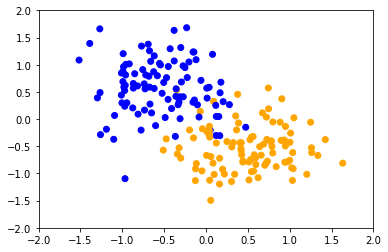

In [57]:
mlp = MLP_target(size=2, mean1=[-0.5, 0.5], cov1=[[0.2, 0.],[0., 0.2]], 
                         mean2=[0.5, -0.5], cov2=[[0.2, 0.],[0., 0.2]],
                 n_samples_per_class=100)
mlp.plot()

In [58]:
#<api>
class MLP_target_XOR (MLP_target):
    '''Special target for MLP widget. Includes samples from two multivariate normal distributions.'''
    
    def __init__(self, size=2, mean=[0.8, 0.8], cov=[[0.1, 0.],[0., 0.1]],
                n_samples_per_class=100):
        self.size = size
        mean = np.array(mean)
        cov = np.array(cov)

        data_samples = np.concatenate((np.random.multivariate_normal(mean, cov, int(n_samples_per_class/2)),\
                        np.random.multivariate_normal(-mean, cov, int(n_samples_per_class/2)),\
                        np.random.multivariate_normal(mean*np.array([1,-1]), cov, int(n_samples_per_class/2)),\
                        np.random.multivariate_normal(mean*np.array([-1,1]), cov, int(n_samples_per_class/2))
                                      )).T
        data_classes = np.concatenate((np.ones(n_samples_per_class), np.zeros(n_samples_per_class)))

        # randomly shuffle data
        permutation = np.random.permutation(data_samples.shape[1])
        data_samples = data_samples[:,permutation]
        self.Z = data_classes[permutation]
        self.X = data_samples[0]
        self.Y = data_samples[1]

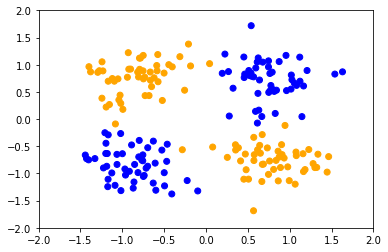

In [59]:
xor = MLP_target_XOR(mean=[0.8, 0.8], cov=[[0.1, 0.],[0., 0.1]],)
xor.plot()